In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
from __future__ import print_function
import numpy as np
import pandas as pd
import sys
import os
import io
import tensorflow as tf
print(tf.__version__)
import codecs
from keras.callbacks import LambdaCallback, ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, Bidirectional
from keras.models import load_model
from tensorflow.keras.utils import plot_model

2.4.1


In [3]:
sequence_length=10
min_word_frequency=50
step=1
batch_size=12

**Shuffle and split training set**

In [4]:
def shuffle_and_split_training_set(sentences_original, next_original, percentage_test=2):
  print("Shuffling sentences...")
  tmp_sentences=[]
  tmp_next_word=[]
  for i in np.random.permutation(len(sentences_original)):
    tmp_sentences.append(sentences_original[i])
    tmp_next_word.append(next_original[i])
  cut_index=int((1-((percentage_test)/100.0))*len(sentences_original))
  x_train, x_test=tmp_sentences[:cut_index], tmp_sentences[cut_index:]
  y_train, y_test=tmp_next_word[:cut_index], tmp_next_word[cut_index:]
  print("Size of training set=", len(x_train))
  print("Size of test set=", len(y_test))
  return (x_train, x_test), (y_train, y_test)

**Generator function**

In [5]:
def generator(sentence_list, next_word_list, batch_size):
  index=0
  while True:
    x=np.zeros((batch_size, sequence_length, len(words)), dtype=np.bool)
    y=np.zeros((batch_size, len(words)), dtype=np.bool)
    for i in range(batch_size):
      for t, w in enumerate(sentence_list[index%len(sentence_list)]):
        x[i, t, word_indices[w]]=1
      y[i, word_indices[next_word_list[index%len(sentence_list)]]]=1
      index+=1
    yield x, y

**Write generated vocabulary to a file**

In [6]:
def print_vocabulary(words_file_path, words_set):
  words_file=codecs.open(words_file_path, 'w', encoding='utf8')
  for w in words_set:
    if (w!='\n'):
      words_file.write(w+"\n")
    else:
      words_file.write(w)
  words_file.close()

**Build an LSTM Model**

In [7]:
def get_model(dropout=0.2):
    print('Build model...')
    model=tf.keras.Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(sequence_length, len(words))))
    if dropout>0:
      model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    if dropout>0:
      model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    if dropout>0:
      model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(512)))
    if dropout > 0:
        model.add(Dropout(dropout))
    model.add(Dense(len(words)))
    model.add(Activation('softmax'))
    print("Done!")
    return model

In [8]:
def sample(preds, temperature=1.0):
  preds=np.asarray(preds).astype('float64')
  preds=np.log(preds)/temperature
  exp_preds=np.exp(preds)
  preds=exp_preds/sum(exp_preds)
  probas=np.random.multinomial(1, preds, 1)
  return np.argmax(probas)

**Behavior at the end of an epoch**

In [9]:
def on_epoch_end(epoch, logs):
  examples_file.write("\n---Generating text after epoch %d\n"%epoch)
  seed_index=np.random.randint(len(sentences_train+sentences_test))
  seed=(sentences_train+sentences_test)[seed_index]
  diversity_array=np.arange(0.3, 0.8, 0.1)
  for diversity in diversity_array:
    sentence=seed
    diversity_string="\n---Diversity=%s.\n"%str(diversity)
    joined=' '.join(sentence)
    seed_sentence="\n---Seed sentence:%s.\n"%joined
    examples_file.write(diversity_string)
    examples_file.write(seed_sentence)
    examples_file.write(joined)
    examples_file.write('\n')
    for i in range(50):
      x_pred=np.zeros((1, sequence_length, len(words)))
      for t, word in enumerate(sentence):
        x_pred[0, t, word_indices[word]]=1
      preds=model.predict(x_pred, verbose=1)[0]
      next_index=sample(preds, diversity)
      next_word=indices_word[next_index]
      sentence=sentence[1:]
      sentence.append(next_word)
    examples_file.write(" "+next_word)
  examples_file.write("\n")
  examples_file.flush()

**Robert Jordan**

In [10]:
corpus='/content/gdrive/MyDrive/Project folder/Author text files/Robert Jordan.txt'
examples='/content/gdrive/MyDrive/Project folder/Authorwise examples/examples_robert_jordan.txt'
vocabulary='/content/gdrive/MyDrive/Project folder/Authorwise vocabulary/vocabulary_robert_jordan.txt'

In [11]:
if not os.path.isdir('/content/gdrive/MyDrive/Project folder/Authorwise text generation/Robert Jordan/checkpoints'):
  os.makedirs('/content/gdrive/MyDrive/Project folder/Authorwise text generation/Robert Jordan/checkpoints')

In [14]:
#with io.open(corpus, encoding='utf-8') as file:
file=open(corpus, encoding='utf8')
text=file.read().lower().replace('\n', '\n ')
print('Corpus length in characters=', len(text))

Corpus length in characters= 22759953


In [15]:
text_in_words=[w for w in text.split(' ') if w.strip()!='' or w=='\n']
print("Corpus length in words=", len(text_in_words))

Corpus length in words= 4150175


In [16]:
word_freq={}
for word in text_in_words:
  word_freq[word]=1+word_freq.get(word, 0)

In [17]:
len(word_freq)

109911

In [18]:
ignored_words=set('\n')
for k, v in word_freq.items():
  if word_freq[k]<min_word_frequency:
    ignored_words.add(k)

In [19]:
words=set(text_in_words)
print("Unique words before ignoring:", len(words))
words=sorted(set(text_in_words)-ignored_words)
print("Unique words after ignoring:", len(words))
print_vocabulary(vocabulary, words)

Unique words before ignoring: 109911
Unique words after ignoring: 6303


In [20]:
word_indices=dict((c, i) for i, c in enumerate(words))
indices_word=dict((i, c) for i, c in enumerate(words))

In [21]:
sentences=[]
next_words=[]
ignored=0
print("Generating sequences...", end="")
for i in range(0, len(text_in_words)-sequence_length, step):
  if (len(set(text_in_words[i:i+sequence_length+1]).intersection(ignored_words))==0):
    sentences.append(text_in_words[i:i+sequence_length])
    next_words.append(text_in_words[i+sequence_length])
  else:
    ignored+=1
print("Done!")

Generating sequences...Done!


In [22]:
print("Total ignored sequences: ", ignored)
print("Remaning sentences: ", len(sentences))
print("Number of words: ", len(next_words))

Total ignored sequences:  3023390
Remaning sentences:  1126775
Number of words:  1126775


In [23]:
(sentences_train, sentences_test), (next_words_train, next_words_test)=shuffle_and_split_training_set(sentences, next_words)

Shuffling sentences...
Size of training set= 1104239
Size of test set= 22536


In [24]:
model=get_model()

Build model...
Done!


In [25]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

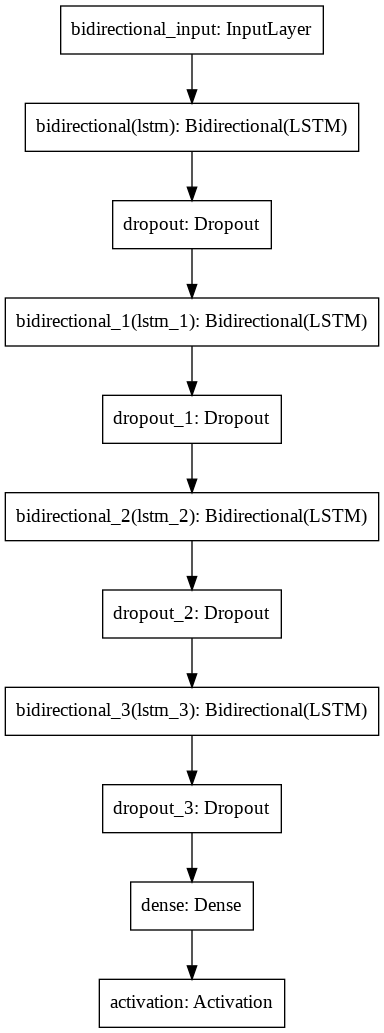

In [27]:
plot_model(model, to_file='Robert Jordan Model.png')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 10, 256)           6586368   
_________________________________________________________________
dropout (Dropout)            (None, 10, 256)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 10, 256)           394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 256)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 10, 512)           1050624   
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 512)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 1024)              4

In [ ]:
examples_file=open(examples, "w")

In [ ]:
file_path = "//content/gdrive/MyDrive/Project folder/Authorwise text generation/Robert Jordan/checkpoints/METG-epoch{epoch:03d}-words%d-sequence%d-minfreq%d-" \
                "loss{loss:.4f}-accuracy{accuracy:.4f}-val_loss{val_loss:.4f}-val_accuracy{val_accuracy:.4f}" % \
                (len(words), sequence_length, min_word_frequency)

In [ ]:
checkpoint=ModelCheckpoint(file_path, monitor='val_accuracy', save_best_only=True)
print_callback=LambdaCallback(on_epoch_end=on_epoch_end)
early_stopping=EarlyStopping(monitor='val_accuracy', patience=1)
callbacks_list=[checkpoint, print_callback, early_stopping]

In [ ]:
with tf.device('/gpu:0'):
  model.fit_generator(generator(sentences_train, next_words_train, batch_size), 
                    steps_per_epoch=int(len(sentences_train)/batch_size)+1, 
                    epochs=12, 
                    callbacks=callbacks_list, 
                    validation_data=generator(sentences_test, next_words_test, batch_size), 
                    validation_steps=int(len(sentences_test)/batch_size)+1)
from keras.models import model_from_json
model_json=model.to_json()
with open("/content/gdrive/MyDrive/Project folder/Authorwise text generation/model_robert_jordan.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("/content/gdrive/MyDrive/Project folder/Authorwise text generation/model_robert_jordan.h5")
print("Saved model to disk!")

Epoch 1/12
    1/92020 [..............................] - ETA: 2:04:55 - loss: 6.8445 - accuracy: 0.0000e+00

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


92020/92020 [==============================] - 4973s 54ms/step - loss: 5.6331 - accuracy: 0.1341 - val_loss: 5.1540 - val_accuracy: 0.1671


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Robert Jordan/checkpoints/METG-epoch001-words6303-sequence10-minfreq50-loss5.6331-accuracy0.1341-val_loss5.1540-val_accuracy0.1671/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Robert Jordan/checkpoints/METG-epoch001-words6303-sequence10-minfreq50-loss5.6331-accuracy0.1341-val_loss5.1540-val_accuracy0.1671/assets


1/1 [==============================] - 0s 31ms/step
Epoch 2/12
92020/92020 [==============================] - 4960s 54ms/step - loss: 5.0985 - accuracy: 0.1717 - val_loss: 4.9924 - val_accuracy: 0.1805


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Robert Jordan/checkpoints/METG-epoch002-words6303-sequence10-minfreq50-loss5.0985-accuracy0.1717-val_loss4.9924-val_accuracy0.1805/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Robert Jordan/checkpoints/METG-epoch002-words6303-sequence10-minfreq50-loss5.0985-accuracy0.1717-val_loss4.9924-val_accuracy0.1805/assets


1/1 [==============================] - 0s 31ms/step
Epoch 3/12
92020/92020 [==============================] - 4923s 54ms/step - loss: 4.9246 - accuracy: 0.1857 - val_loss: 4.9196 - val_accuracy: 0.1895


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Robert Jordan/checkpoints/METG-epoch003-words6303-sequence10-minfreq50-loss4.9246-accuracy0.1857-val_loss4.9196-val_accuracy0.1895/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Robert Jordan/checkpoints/METG-epoch003-words6303-sequence10-minfreq50-loss4.9246-accuracy0.1857-val_loss4.9196-val_accuracy0.1895/assets


1/1 [==============================] - 0s 34ms/step
Epoch 4/12
92020/92020 [==============================] - 4901s 53ms/step - loss: 4.7929 - accuracy: 0.1982 - val_loss: 4.8737 - val_accuracy: 0.1963


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Robert Jordan/checkpoints/METG-epoch004-words6303-sequence10-minfreq50-loss4.7929-accuracy0.1982-val_loss4.8737-val_accuracy0.1963/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Robert Jordan/checkpoints/METG-epoch004-words6303-sequence10-minfreq50-loss4.7929-accuracy0.1982-val_loss4.8737-val_accuracy0.1963/assets


1/1 [==============================] - 0s 30ms/step
Epoch 5/12
92020/92020 [==============================] - 4871s 53ms/step - loss: 4.6852 - accuracy: 0.2085 - val_loss: 4.8742 - val_accuracy: 0.1964


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Robert Jordan/checkpoints/METG-epoch005-words6303-sequence10-minfreq50-loss4.6852-accuracy0.2085-val_loss4.8742-val_accuracy0.1964/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Robert Jordan/checkpoints/METG-epoch005-words6303-sequence10-minfreq50-loss4.6852-accuracy0.2085-val_loss4.8742-val_accuracy0.1964/assets


1/1 [==============================] - 0s 30ms/step
Epoch 6/12
92020/92020 [==============================] - 4862s 53ms/step - loss: 4.5852 - accuracy: 0.2181 - val_loss: 4.8816 - val_accuracy: 0.1966


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Robert Jordan/checkpoints/METG-epoch006-words6303-sequence10-minfreq50-loss4.5852-accuracy0.2181-val_loss4.8816-val_accuracy0.1966/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Robert Jordan/checkpoints/METG-epoch006-words6303-sequence10-minfreq50-loss4.5852-accuracy0.2181-val_loss4.8816-val_accuracy0.1966/assets


1/1 [==============================] - 0s 30ms/step
Epoch 7/12
1/1 [==============================] - 0s 30ms/step


In [ ]:
model_file="/content/gdrive/MyDrive/Project folder/Authorwise text generation/Robert Jordan/checkpoints/METG-epoch006-words6303-sequence10-minfreq50-loss4.5852-accuracy0.2181-val_loss4.8816-val_accuracy0.1966"
from keras.models import load_model
model=load_model(model_file)

In [ ]:
model=get_model()
model.load_weights("/content/gdrive/MyDrive/Project folder/Authorwise text generation/model_robert_jordan.h5")

Build model...
Done!


**Generate Text**

In [ ]:
def generate_text(model, indices_word, word_indices, 
                  seed, sequence_length, diversity, 
                  quantity, vocabulary, write_path, 
                  write_to_file=False, authorname=""):
  sentence=seed.split(" ")
  print("====Generating text====")
  print("Diversity: ", diversity)
  print("Seed sentence:",seed)
  counter=1
  full_appended_sentence=seed
  print(seed, end="")
  for i in range(quantity):
    x_pred=np.zeros((1, sequence_length, len(vocabulary)))
    for t, word in enumerate(sentence):
      x_pred[0, t, word_indices[word]]=1
    preds=model.predict(x_pred, verbose=0)[0]
    next_index=sample(preds, diversity)
    next_word=indices_word[next_index]
    sentence=sentence[1:]
    sentence.append(next_word)
    print(" "+word, end="")
    full_appended_sentence=full_appended_sentence+" "+word
    if (counter%10==0):
      print("")
      full_appended_sentence=full_appended_sentence+"\n"
    counter+=1
  print("\n")
  if (write_to_file is True):
    filename=write_path+authorname+"_"+str(diversity)+"_"+str(quantity)+".txt"
    print("Writing to file...", end="")
    f=open(filename, "w")
    f.write(full_appended_sentence)
    print("Done!")
    f.close()

In [ ]:
vocabulary_file="/content/gdrive/MyDrive/Project folder/Authorwise vocabulary/vocabulary_robert_jordan.txt"

In [ ]:
##model=load_model(model_file)
vocabulary=open(vocabulary_file, "r").readlines()
print(len(vocabulary))

6303


In [ ]:
import re
vocabulary = sorted(set([re.sub(r'(\S+)\s+', r'\1', w) for w in vocabulary]))

In [ ]:
word_indices=dict((c, i) for i, c in enumerate(words))
indices_word=dict((i, c) for i, c in enumerate(words))

In [ ]:
seed_index=np.random.randint(len(sentences_train+sentences_test))
seed=(sentences_train+sentences_test)[seed_index]
seed=" ".join(seed)
print("==========================================")
print("Seed sentence:", seed)
print("==========================================")
diversity_array=np.arange(0.3, 1.1, 0.1)
for diversity in diversity_array:
  quantity=300
  generate_text(model, indices_word, word_indices, 
                seed, sequence_length, diversity, 
                quantity, words, 
                "/content/gdrive/MyDrive/Project folder/Author text generation/Robert Jordan/", 
                True, "Robert Jordan")
  print("=====================================================")

Seed sentence: as the aes sedai did, but with absolutely no expression.
====Generating text====
Diversity:  0.3
Seed sentence: as the aes sedai did, but with absolutely no expression.
as the aes sedai did, but with absolutely no expression. expression. she was not sure she had to see how
 to get away from the wise ones in the tower
 without a great deal of it. she was not going
 to be able to see what she had done to
 her. she had not seen any of her things in
 the tower in the first place. she had been the
 first time she had been in a few days, but
 she would not be able to do anything else. he
 had no need to go to the tower as a
 woman who can channel. i will not be able to
 do what i can to do with that very few
 of you in any case, but i will not be
 able to see you in the white tower in the
 tower and the tower in the first place. it was
 the first time she had seen the two rivers men
 in the room to be called a few days, but
 there was no need to be a good many times
 in the fi

In [ ]:
seed_index=np.random.randint(len(sentences_train+sentences_test))
seed=(sentences_train+sentences_test)[seed_index]
seed=" ".join(seed)
print("==========================================")
print("Seed sentence:", seed)
print("==========================================")
diversity_array=np.arange(0.3, 1.1, 0.1)
for diversity in diversity_array:
  quantity=10500
  generate_text(model, indices_word, word_indices, seed, sequence_length, diversity, quantity, words, 
                "/content/gdrive/MyDrive/Project folder/Author text generation/Robert Jordan/", True, "Robert Jordan")
  print("=====================================================")

Seed sentence: power would hit him, but after that, he could barely
====Generating text====
Diversity:  0.3
Seed sentence: power would hit him, but after that, he could barely
power would hit him, but after that, he could barely barely see what he had done to the white tower
 as a man who could channel. i have to be
 on the other side of the palace as soon as
 the wise ones had been in the first place. she
 had not seen any of the other women at all.
 they were not going to be able to make out
 the best of it. she had no need to be
 a good many days ago. the seanchan were not a
 good many years older than the aes sedai as a
 man who could channel. if they were not going to
 be the dragon reborn. he had not seen any of
 the men in the white tower. the wise ones were
 not so sure as any of the others who had
 been in the two rivers, but the two of them
 were not a good many years older than the wise
 ones and the others to be called the first of
 the two rivers men who had been called to

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


Streaming output truncated to the last 5000 lines.
 were. if they could remember how to keep it from
 the wise ones and the wise ones who had not
 been called a man of a lord or a woman.
 the last of the wise ones had said he was
 in the dream, but he could not imagine what she
 could do if she could not see whether she had
 to make him think of it, but she was sure
 he would not ask me to tell me how to
 do it, my lord dragon, i have to give me
 a look of his own own. we are too impossible
 to do with that if you are too late. i
 will have to change my own own for a purpose
 to accept the dragon reborn. the seanchan had not been
 so called to tell him that he would walk out
 of the common room. he asked the seanchan in the
 city, only a few days ago. and the winds of
 the light. all the men who had been called the
 rest of the aiel. i can have to make sure
 it is the my lord captain will deal with the
 seanchan with the ships we can have to be left
 talking to me before i could do the